In [1]:
#%% Library
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
homedir = '/Users/hhchoi1022/Gitrepo/7DT/SPHEREx'
os.chdir(homedir)
from spherex_helper import tophat_trans
from scipy.ndimage import gaussian_filter
from scipy.integrate import trapezoid

#%% Constant
h = 6.626e-27
c = 3e10
rad2arcsec = (180/np.pi*3600)
arcsec2rad = 1/rad2arcsec


##### Filter info : filter_set
##### Total response info : response
##### Parameters
"""
    fwhm    <<< fwhm for aperture
    texp    <<< exposure time
    lambda_7ds    <<< filterset construction
    wave_lvf    <<< [um] lamb_start, lamb_end
    eff_mirrors    <<< efficiency of the mirror
    eff_optics    <<< efficiency of the optics
    eff_filter    <<< efficiency of the filter
    and many configuration for the telescope & detector
"""

'\n    fwhm    <<< fwhm for aperture\n    texp    <<< exposure time\n    lambda_7ds    <<< filterset construction\n    wave_lvf    <<< [um] lamb_start, lamb_end\n    eff_mirrors    <<< efficiency of the mirror\n    eff_optics    <<< efficiency of the optics\n    eff_filter    <<< efficiency of the filter\n    and many configuration for the telescope & detector\n'

(0.0, 1.2)

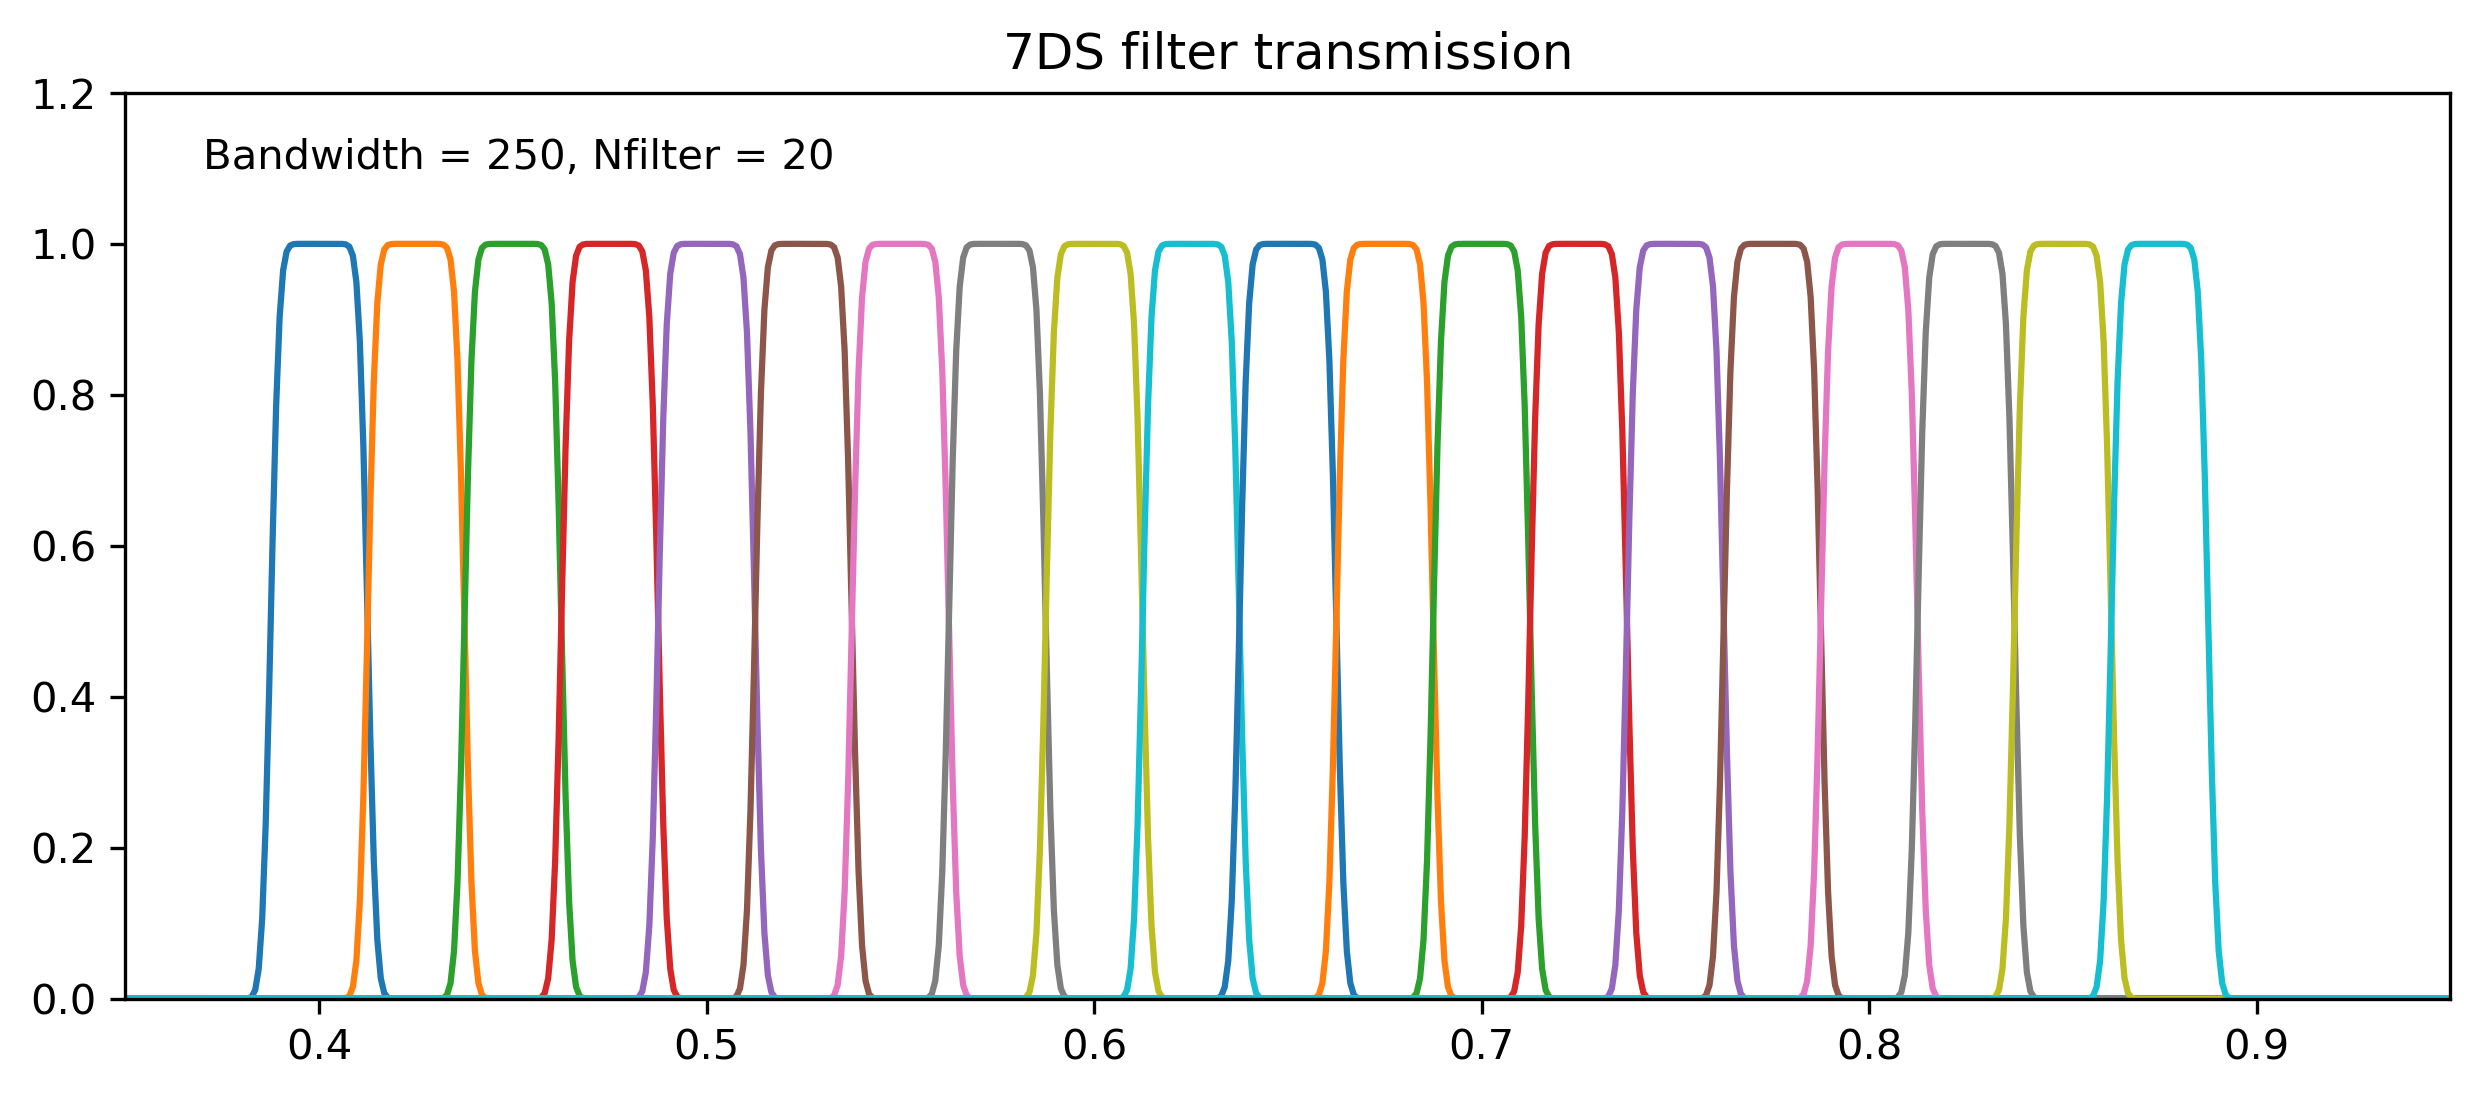

In [2]:
#%% Filter
fwhm = 250 # [Angstrom] FWHM #########################CHANGABLE#############################
lambda_7ds = np.arange(4000., 9000., 250)   #########################CHANGABLE#############################
wave_lvf = np.linspace(0.1, 1.0, 1001)  #########################CHANGABLE#############################

# Create filter_set definition
filter_set = {'cwl': lambda_7ds,
              'wave': wave_lvf}
plt.figure(figsize=(10, 4), dpi = 300)
plt.title('7DS filter transmission')
for ii, wl_cen in enumerate(lambda_7ds):
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    filter_set.update({f'{ii}': resp_lvf})
    plt.plot(wave_lvf, resp_lvf)

plt.text(0.37, 1.1, f'Bandwidth = {fwhm}, Nfilter = {len(lambda_7ds)}')
plt.xlim(0.35, 0.95)
plt.ylim(0.00, 1.20)

Text(0.5, 1.0, 'IMX455')

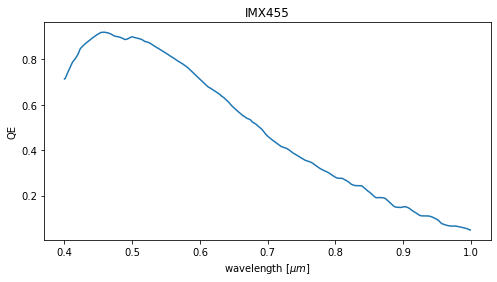

In [3]:
#%% Telescope 
# Mirror
D = 50.5  #########################CHANGABLE#############################
D_obs = 29.8  #########################CHANGABLE#############################
EFL = 1537.3    # [mm]   #########################CHANGABLE#############################
D_eff = np.sqrt(D**2 - D_obs**2)
# Detector
dQ_RN = 3.51           # [e], readout noise   #########################CHANGABLE#############################
I_dark = 0.005        # [e/s], dark current  #########################CHANGABLE#############################
pixel_size = 3.76    # [um], "pitch"  #########################CHANGABLE#############################
theta_pixel = 0.517  # [arcsec], pixel scale  #########################CHANGABLE############################# 
nxpix, nypix = 9576, 6388  # [pixels], detector format, approx. 9k x 6k  #########################CHANGABLE#############################
# QE for the detector(IMX455)
T_qe = Table.read('/Users/hhchoi1022/Gitrepo/7DT/data/IMX455_QE.csv', format = 'ascii', names =('wavelength', 'QE'))
T_qe['wavelength'] = T_qe['wavelength'].astype(float)
T_qe['wavelength'].unit = u.um
plt.figure(figsize=(8,4))
plt.plot(T_qe['wavelength'], T_qe['QE'], '-')
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('QE')
plt.title('IMX455')

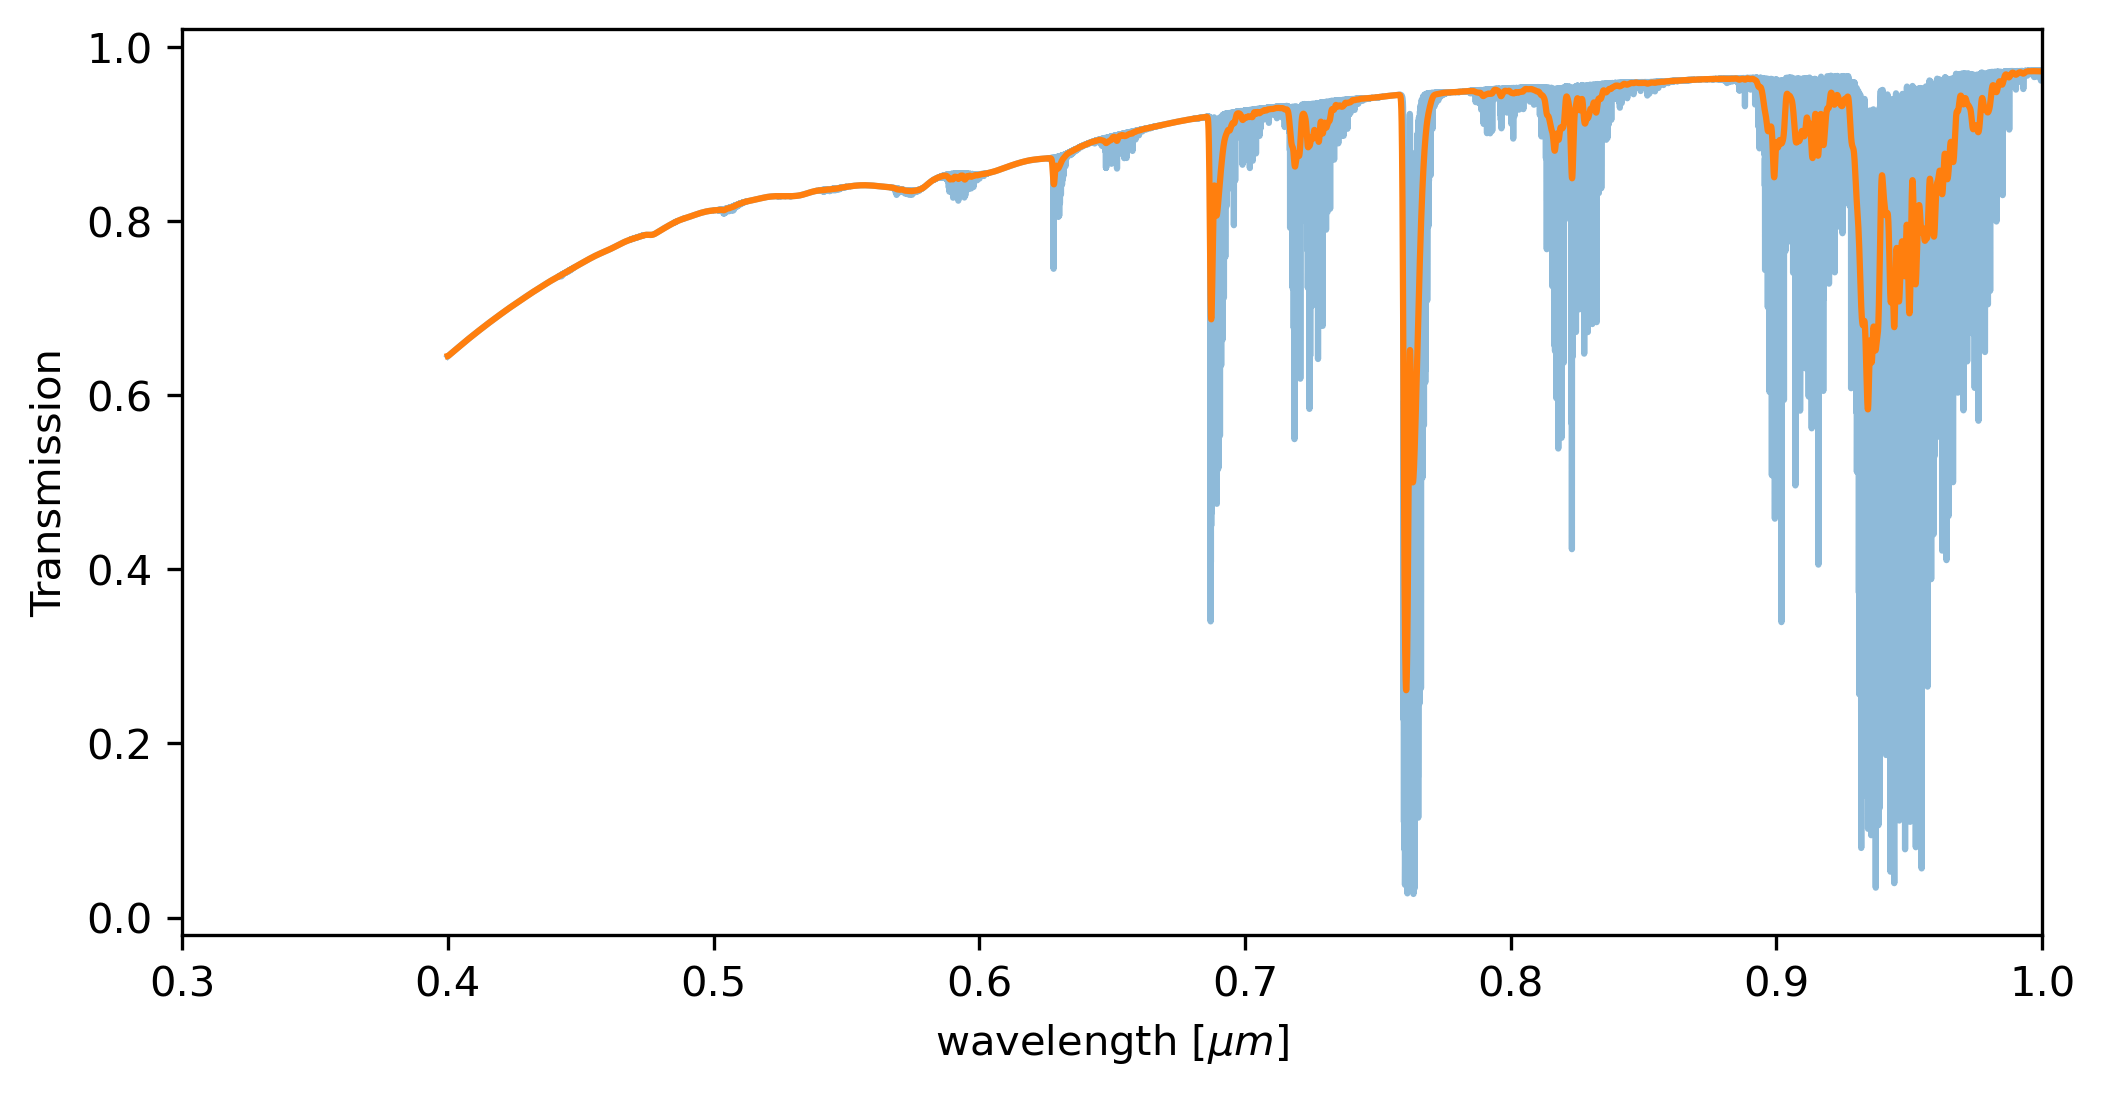

In [4]:
#%% Atmospheric transmission
# For sky model, more info here: https://www.eso.org/sci/software/pipelines/skytools/skycalc
# Model parameter
    # 4000~10000AA
    # altitude = 45degree
    # PMW = 2.5mm
atm = Table.read('/Users/hhchoi1022/Gitrepo/7DT/data/transmission_atm_45')
plt.figure(figsize=(8,4), dpi = 300)
plt.plot(atm['lam']/1e3, atm['trans'], alpha=0.5)
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
plt.xlim(0.3,1)
trans_smooth = gaussian_filter(atm['trans'], 10)
plt.plot(atm['lam']/1e3, trans_smooth)

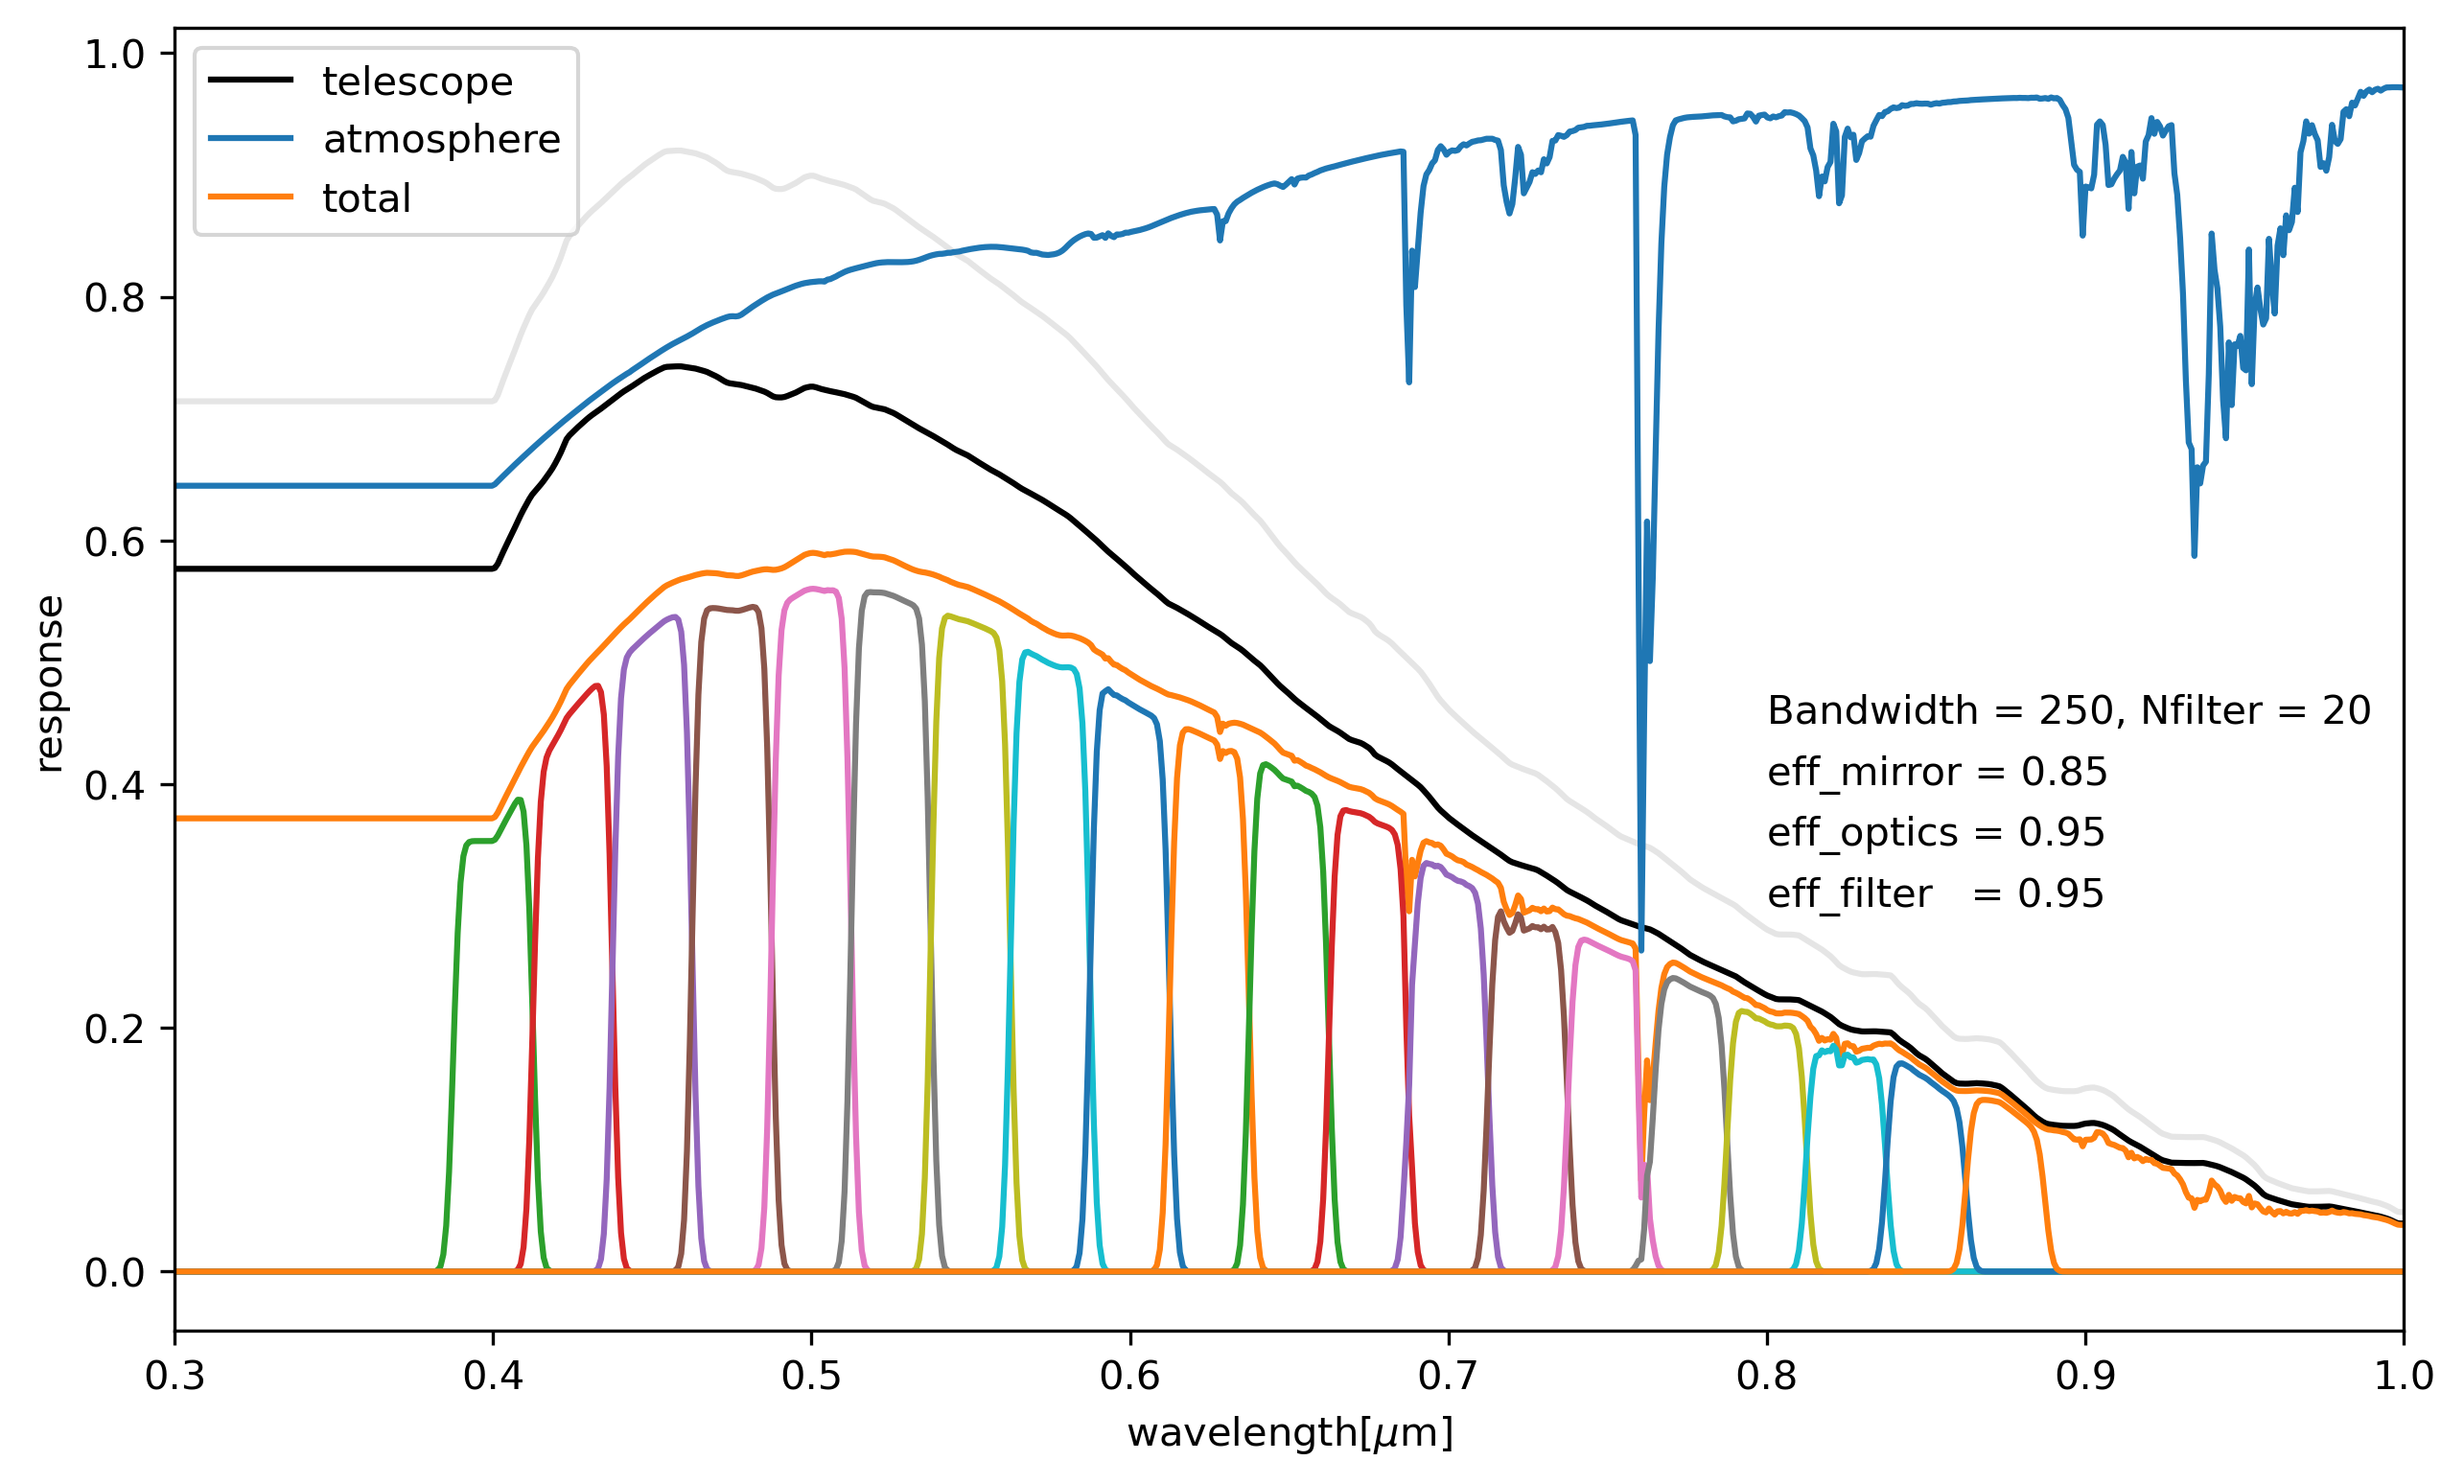

In [5]:
#%% Total response curve (Telescope + Atmosphere + Filter )
eff_mirrors = round(0.92 **2,2) #########################CHANGABLE#############################
eff_optics = 0.95   #########################CHANGABLE#############################
eff_filter = 0.95   #########################CHANGABLE#############################
response = {'cwl': lambda_7ds,
            'wave': wave_lvf}

cwl = filter_set['cwl'][0]
intp_tel = np.interp(wave_lvf, T_qe['wavelength'], T_qe['QE'] * eff_mirrors * eff_optics)
intp_atm = np.interp(wave_lvf, atm['lam']*1e-3, trans_smooth)
intp_tot = intp_tel * intp_atm
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(wave_lvf, intp_tel, label = 'telescope', c='k')
plt.plot(wave_lvf, intp_tel / eff_mirrors / eff_optics, alpha = 0.1, c='k')
plt.plot(wave_lvf, intp_atm, label = 'atmosphere')
plt.plot(wave_lvf, intp_tot, label = 'total')
plt.text(0.8, 0.45, f'Bandwidth = {fwhm}, Nfilter = {len(lambda_7ds)}')
plt.text(0.8,0.4, f'eff_mirror = {eff_mirrors}')
plt.text(0.8,0.35,f'eff_optics = {eff_optics}')
plt.text(0.8,0.3, f'eff_filter   = {eff_filter}')
for i in range(len(lambda_7ds)):
    resp_tot = intp_tot * filter_set[f'{i}'] * eff_filter
    plt.plot(wave_lvf, resp_tot)
    response.update({f'{i}':resp_tot})
plt.xlim(0.3,1)
plt.xlabel(r'wavelength[$\mu$m]')
plt.ylabel('response')
plt.legend(loc = 2)
plt.show()


In [149]:
seeing = 1.5
npix_ps = np.pi*(seeing/theta_pixel)**2     # number of pixels of point source
npix_1s = np.pi*(1/theta_pixel)**2     # number of pixels of 1''
texp = 180

In [150]:
#%% Synthetic photometry

def synth_phot(wave, flux, wave_lvf, resp_lvf, tol=1e-3, return_photonrate = False):
    """
    Quick synthetic photometry routine.

    Parameters
    ----------
    wave : `numpy.ndarray`
        wavelength of input spectrum.
    flux : `numpy.ndarray`
        flux density of input spectrum in f_nu unit
        if `return_countrate` = True, erg/s/cm2/Hz is assumed
    wave_lvf : `numpy.ndarray`
        wavelength of the response function
    resp_lvf : `numpy.ndarray`
        response function. assume that this is a QE.
    tol : float, optional
        Consider only wavelength range above this tolerence (peak * tol).
        The default is 1e-3.

    Returns
    -------
    synthethic flux density in the input unit
        if return_photonrate = True, photon rates [ph/s/cm2/arcsec^2]
        else return = [erg/s/cm^2/arcsec^2]

    """
    index_filt, = np.where(resp_lvf > resp_lvf.max()*tol)

    index_flux, = np.where(np.logical_and( wave > wave_lvf[index_filt].min(), 
                                           wave < wave_lvf[index_filt].max() ))

    wave_resamp = np.concatenate( (wave[index_flux], wave_lvf[index_filt]) )
    wave_resamp.sort()
    wave_resamp = np.unique(wave_resamp)
    flux_resamp = np.interp(wave_resamp, wave, flux)
    resp_resamp = np.interp(wave_resamp, wave_lvf, resp_lvf)

    if return_photonrate:
        h_planck = 6.626e-27 # erg/Hz
        return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) / h_planck
        
    return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) / trapezoid(resp_resamp / wave_resamp, wave_resamp)

In [187]:
spectrum = Table.read('../data/M101_spec.fits')
wl_AA_obs = 10**spectrum['loglam']
f_nu_obs = spectrum['flux']*1e-17  * wl_AA_obs * wl_AA_obs*1e-8 / c # [erg/s/cm^2/Hz]

In [188]:
spectrum = Table.read('../data/transmission_atm_45')
wl_AA_sky = spectrum['lam']*1e1
nu_sky = 3e18 / wl_AA_sky
I_lambda = spectrum['flux']
f_lambda = I_lambda * (h * nu_sky) / (1e2**2) / (1e4)   # [erg/s/cm^2/AA/arcsec^2]
f_nu_atm = f_lambda  * wl_AA_sky * wl_AA_sky*1e-8 / c # [erg/s/cm^2/Hz/arcsec^2]

In [198]:
T_sens = (Table( 
             names=('band', 'wavelength', 'I_photo_sky', 'mag_pxl', 'mag_pts', 'UL5_pxl', 'UL5_pts','SN','SN_dI'),
             dtype=(np.int16,float,float,float,float,float,float,float,float,) )
         )
for key in T_sens.colnames:
    T_sens[key].info.format = '.4g'
for i, cwl in enumerate(response['cwl']): 
    photon_rate = synth_phot(wl_AA_obs*1e-4, f_nu_obs, response['wave'], response[f'{i}'], return_photonrate= True)
    SB_photo = synth_phot(wl_AA_obs*1e-4, f_nu_obs, response['wave'], response[f'{i}'], return_photonrate= False)
    
    # photo-current or count rate
    I_photo = photon_rate * (np.pi/4*D_eff**2) * (theta_pixel**2)
    
    # noise in count per obs [e]. 
    Q_photo = (I_photo+I_dark)*texp
    dQ_photo = np.sqrt(Q_photo)
    
    # noise in count rate [e/s]
    # read-noise (indistinguishable from signal) should be added 
    dI_photo = np.sqrt(dQ_photo**2 + dQ_RN**2)/texp
    SN_dI = I_photo/dI_photo
    
    # surface brightness [per arcsec]
    dSB_photo = (dI_photo/I_photo)*SB_photo
    mag_pxl = -2.5*np.log10(SB_photo) - 48.60
    mag_pxl_lim = -2.5*np.log10(5*dSB_photo) - 48.60
    
    # point source
    dFnu = np.sqrt(npix_ps) * dSB_photo*(theta_pixel)**2
    Fnu = SB_photo
    mag_pts = -2.5*np.log10(Fnu) - 48.60
    mag_pts_lim = -2.5*np.log10(5*dFnu) - 48.60
    
    def pointsrc_signal2noise(mag_src, Tsamp):
        """
        Calculate SN for a point source

        Input
            mag_src: AB mag of the source, scalar
            Tsamp: individual exposure time [sec], can be scalar or array

        WARNING: !!! ALL VARIABLES ARE GLOBALLY DECLARED !!!
        """
        # mag_src = 19.7
        Naper = npix_ps 

        # mag_src = 20.1 - 2.5*np.log10(theta_pixel**2)
        # Naper = 1

        f_nu_src = f_nu_atm*0 + 10**(-0.4*(mag_src + 48.6))                   # erg/s/cm2/Hz
        f_nu_sky = f_nu_atm                     # erg/s/cm2/Hz/arcsec2

        photon_rate_src = synth_phot(wl_AA_sky*1e-4, f_nu_src, response['wave'], response[f'{i}'], return_photonrate=True)  # ph/s/cm2
        photon_rate_sky = synth_phot(wl_AA_sky*1e-4, f_nu_sky, response['wave'], response[f'{i}'], return_photonrate=True)  # ph/s/cm2/arcsec2

        I_photo_src = photon_rate_src * (np.pi/4*D_eff**2)                     # [e/s] per aperture (no aperture loss)
        I_photo_sky = photon_rate_sky * (np.pi/4*D_eff**2) * (theta_pixel**2)  # [e/s] per pixel 

        Q_photo_src = I_photo_src * Tsamp
        Q_photo_sky = I_photo_sky * Tsamp
        Q_photo_dark = I_dark * Tsamp

        SN = Q_photo_src / np.sqrt(Q_photo_src + Naper*Q_photo_sky + Naper*Q_photo_dark + Naper*dQ_RN**2)

        return SN
    SN = pointsrc_signal2noise(mag_pts, texp)
    # Add data to the table
    T_sens.add_row([i, cwl, I_photo, mag_pxl, mag_pts, mag_pxl_lim, mag_pts_lim, SN, SN_dI]) 

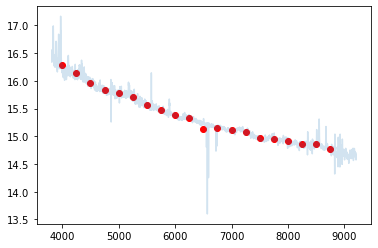

In [199]:
plt.plot(wl_AA_obs, -2.5*np.log10(f_nu_obs)-48.60, alpha = 0.2)
plt.scatter(T_sens['wavelength'], T_sens['mag_pts'], c='r')

In [200]:
T_sens

band,wavelength,I_photo_sky,mag_pxl,mag_pts,UL5_pxl,UL5_pts,SN,SN_dI
int16,float64,float64,float64,float64,float64,float64,float64,float64
0,4000,13.49,16.28,16.28,18.76,18.42,88.31,49.14
1,4250,17.97,16.14,16.14,18.78,18.43,103.3,56.76
2,4500,22.82,15.97,15.97,18.73,18.39,116.7,63.99
3,4750,25.31,15.84,15.84,18.66,18.32,123.5,67.39
4,5000,26.05,15.78,15.78,18.62,18.27,125.6,68.38
5,5250,26.33,15.71,15.71,18.55,18.21,126.5,68.74
...,...,...,...,...,...,...,...,...
13,7250,17.58,15.08,15.08,17.7,17.36,103.1,56.14
14,7500,16.37,14.96,14.96,17.55,17.2,100,54.16


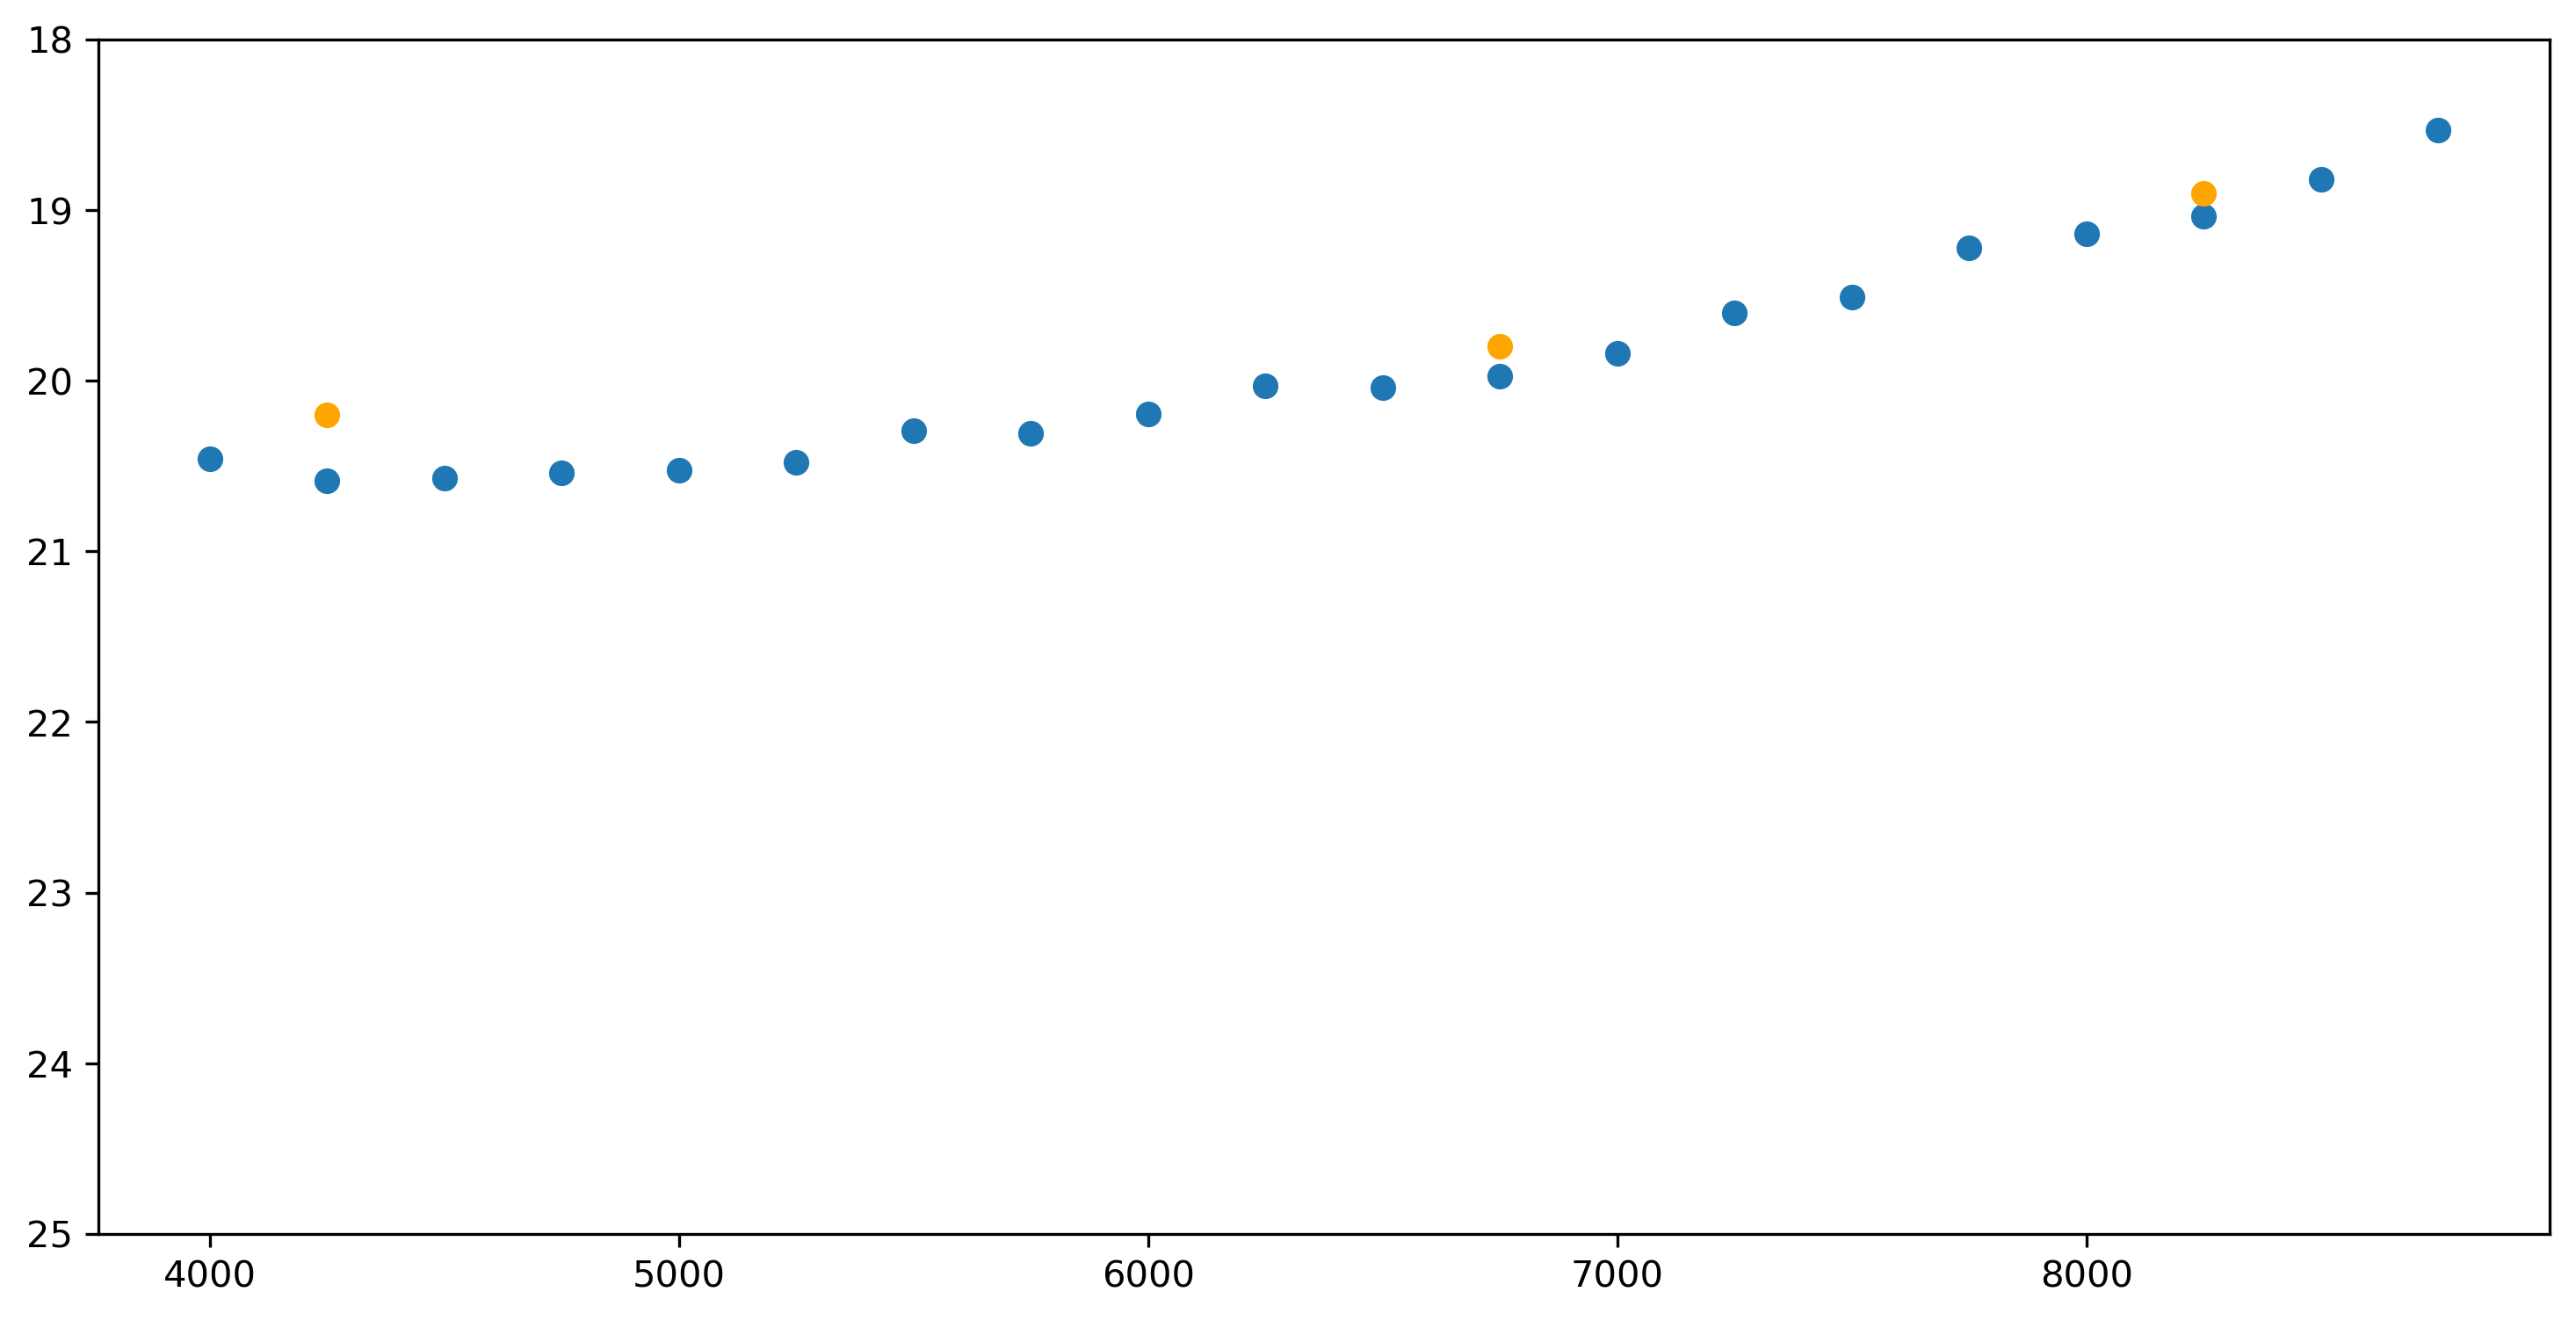

In [177]:
plt.figure(figsize = (12,6), dpi = 300)
plt.ylim(25,18)
plt.plot(np.array([4250, 6750, 8250]), [20.2, 19.8, 18.9], 'o', c='orange')
plt.scatter(T_sens['wavelength'], T_sens['UL5_pts'])

In [178]:
T_sens

band,wavelength,I_photo_sky,mag_pxl,mag_pts,UL5_pxl,UL5_pts,SN,SN_dI
int16,float64,float64,float64,float64,float64,float64,float64,float64
0,4000,0.2409,20.65,20.65,20.81,20.46,3.984,5.765
1,4250,0.2662,20.71,20.71,20.93,20.59,4.23,6.128
2,4500,0.3386,20.54,20.54,20.91,20.57,4.873,7.077
3,4750,0.349,20.49,20.49,20.89,20.54,4.959,7.204
4,5000,0.3384,20.49,20.49,20.87,20.52,4.872,7.075
5,5250,0.3267,20.47,20.47,20.83,20.48,4.773,6.929
...,...,...,...,...,...,...,...,...
13,7250,0.2096,19.89,19.89,19.95,19.6,3.658,5.285
14,7500,0.1609,19.98,19.98,19.86,19.51,3.098,4.46
